# Image Search Engine Using Text
* Dataset: Fashion product images small (https://www.kaggle.com/datasets/paramaggarwal/fashion-product-images-small)
* Model: CLIP
()
* Vector Databases: FAISS

In [2]:
! pip install torch torchvision faiss-cpu datasets
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

In [3]:
import torch
import clip
from PIL import Image
import faiss
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 74.8MiB/s]


## Load Dataset

In [6]:
from datasets import load_dataset

# load the dataset from huggingface datasets hub
fashion = load_dataset(
    "ashraq/fashion-product-images-small",
    split="train"
)
fashion

Generating train split:   0%|          | 0/44072 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
    num_rows: 44072
})

In [7]:
# 이미지와 텍스트 설명 추출
images = fashion["image"]  # 이미지 데이터
texts = fashion["productDisplayName"]  # 텍스트 설명

In [8]:
def process_image(image):
    image = preprocess(image).unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = model.encode_image(image).cpu().detach().numpy()
    return image_embedding

def process_text(text):
  text_token = clip.tokenize([text]).to(device)
  with torch.no_grad():
      text_embedding = model.encode_text(text_token).cpu().detach().numpy()
  return text_embedding

In [9]:
import multiprocessing as mp
# 이미지 및 텍스트 임베딩 생성
image_embeddings = []
text_embeddings = []

# GPU에서 순차적으로 이미지 임베딩 생성
for image in images:
    image_embeddings.append(process_image(image))

# GPU에서 순차적으로 텍스트 임베딩 생성
for text in texts:
    text_embeddings.append(process_text(text))

# # 병렬 처리로 이미지 임베딩 생성
# with mp.Pool(mp.cpu_count()) as pool:
#     image_embeddings = pool.map(process_image, images)

# # 병렬 처리로 텍스트 임베딩 생성
# with mp.Pool(mp.cpu_count()) as pool:
#     text_embeddings = pool.map(process_text, texts)

# numpy array로 변환
image_embeddings = np.vstack(image_embeddings)
text_embeddings = np.vstack(text_embeddings)

# 임베딩을 파일로 저장
np.save('image_embeddings.npy', image_embeddings)
np.save('text_embeddings.npy', text_embeddings)

## FAISS를 이용한 검색 인덱스 구축

In [10]:
# FAISS 인덱스 생성 (L2 거리로 최근접 이웃 검색)
index = faiss.IndexFlatL2(512)  # 512차원 임베딩에 대한 인덱스

# 이미지 임베딩 추가
index.add(image_embeddings)

## 추론하기

In [27]:
import matplotlib.pyplot as plt

def search_images(query_embedding, k=10):
  # FAISS에서 유사한 이미지 검색
  D, I = index.search(query_embedding, k=5)  # k는 반환할 결과의 수

  # 검색된 결과 출력
  for i in range(len(I[0])):
      image_id = I[0][i]
      distance = D[0][i]

      # 이미지 출력
      img = images[image_id]
      plt.imshow(img)
      plt.axis('off')
      plt.title(f"ID: {image_id}, Distance: {distance:.4f}")
      plt.show()

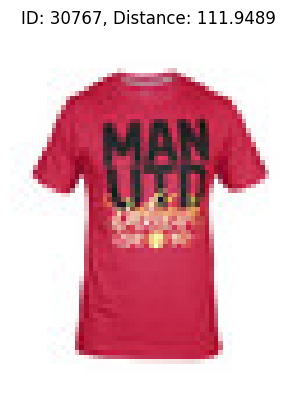

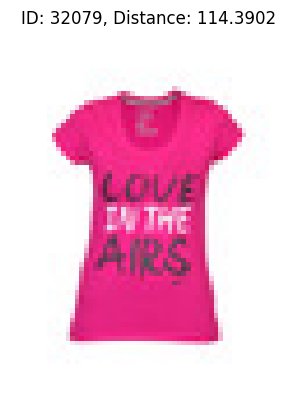

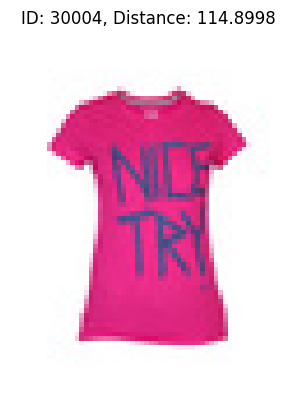

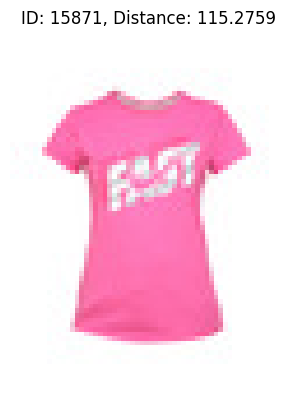

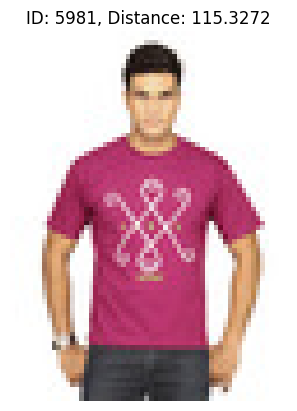

In [31]:
# 검색할 텍스트 쿼리 입력
query = "pink t-shirt"
query_embedding = model.encode_text(clip.tokenize([query]).to(device)).cpu().detach().numpy()
search_images(query_embedding)

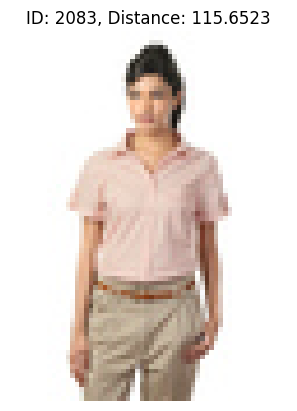

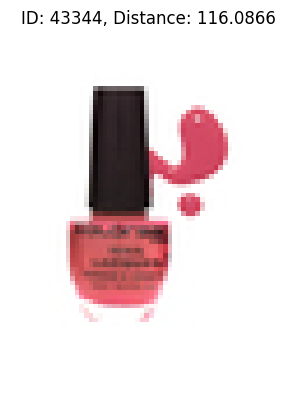

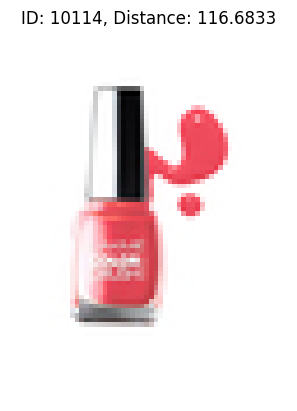

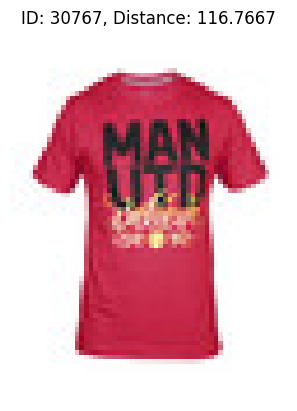

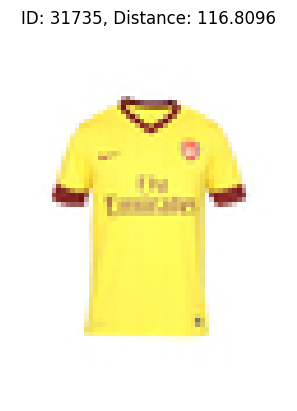

In [32]:
# 검색할 텍스트 쿼리 입력
query = "pink blouse"
query_embedding = model.encode_text(clip.tokenize([query]).to(device)).cpu().detach().numpy()
search_images(query_embedding)

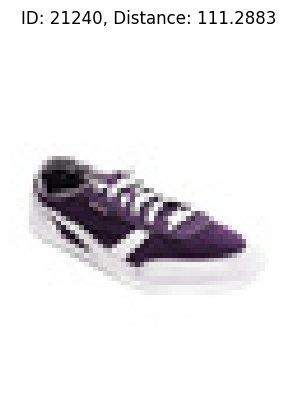

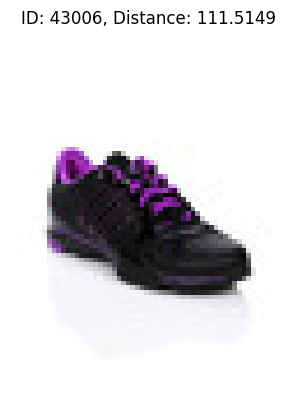

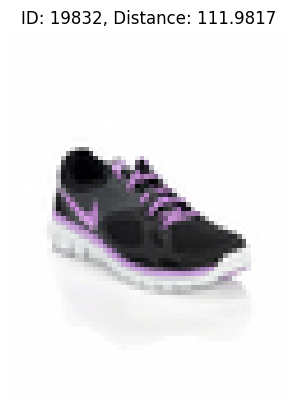

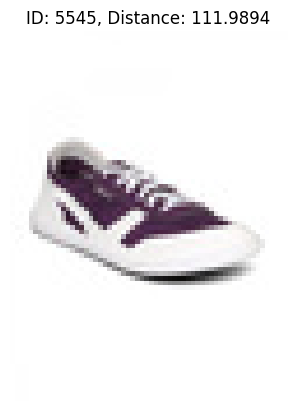

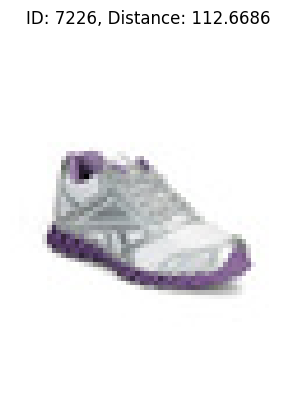

In [29]:
# 검색할 텍스트 쿼리 입력
query = "purple shoes"
query_embedding = model.encode_text(clip.tokenize([query]).to(device)).cpu().detach().numpy()
search_images(query_embedding)

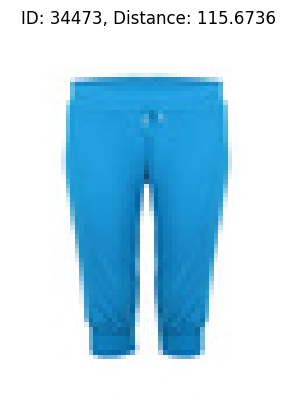

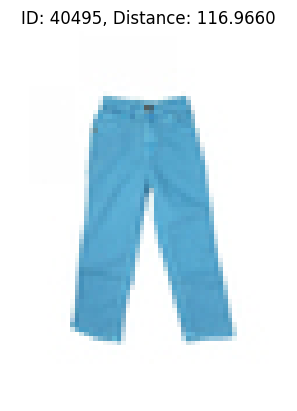

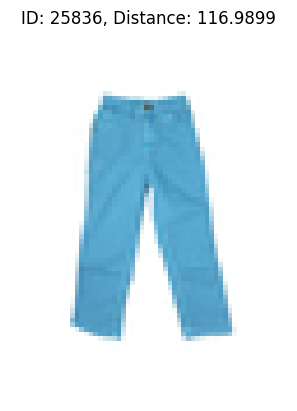

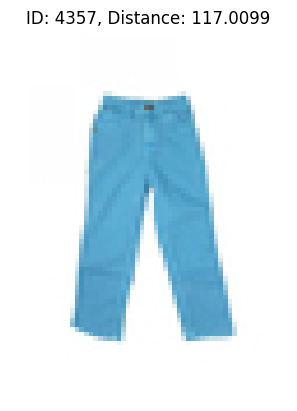

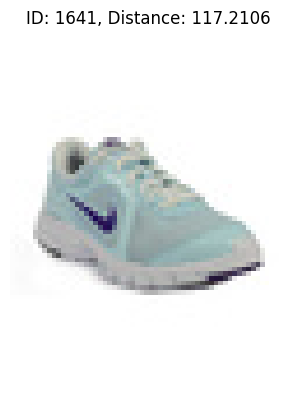

In [34]:
# 검색할 텍스트 쿼리 입력
query = "blue long pants"
query_embedding = model.encode_text(clip.tokenize([query]).to(device)).cpu().detach().numpy()
search_images(query_embedding)